In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas as pd
import warnings
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import trange
import os

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)

import tensorflow.keras as keras

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

## 데이터셋 로드

In [3]:
train_df = pd.read_csv('./dataset/train/train_data.csv')
test_df = pd.read_csv('./dataset/test/test_data.csv')
submission_csv = pd.read_csv('./dataset/sample_submission.csv')

In [55]:
train_file_dir = 'dataset/train/'
test_file_dir = 'dataset/test/'

# 데이터 저장할 공간 생성
x_train = np.zeros((len(train_df), 28, 28, 1))
y_train = train_df['label']

x_test = np.zeros((len(test_df), 28, 28, 1))

for i, image_name in enumerate(train_df['filen_name']):
    
    x_train[i] = np.reshape(np.array(Image.open(train_file_dir + image_name)), (28, 28, 1))

for i, image_name in enumerate(test_df['file_name']):
    
    x_test[i] = np.reshape(np.array(Image.open(test_file_dir + image_name)), (28, 28, 1))

In [5]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)

In [23]:
# XAI를 수행하기 위해 사전 딥러닝 모델을 학습
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers

checkpoint_path = './model'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=100, shuffle=True, validation_data=(X_validation, Y_validation), callbacks=[model_checkpoint_callback],)

model.trainable = False

model.load_weights(checkpoint_path)

Epoch 1/100
141/141 [==============================] - 1s 7ms/step - loss: 1.3450 - accuracy: 0.7998 - val_loss: 0.2040 - val_accuracy: 0.9320
Epoch 2/100
141/141 [==============================] - 1s 7ms/step - loss: 0.1044 - accuracy: 0.9664 - val_loss: 0.1765 - val_accuracy: 0.9480
Epoch 3/100
141/141 [==============================] - 1s 7ms/step - loss: 0.0550 - accuracy: 0.9804 - val_loss: 0.1412 - val_accuracy: 0.9700
Epoch 4/100
141/141 [==============================] - 1s 7ms/step - loss: 0.0287 - accuracy: 0.9898 - val_loss: 0.1118 - val_accuracy: 0.9680
Epoch 5/100
141/141 [==============================] - 1s 7ms/step - loss: 0.0141 - accuracy: 0.9951 - val_loss: 0.1554 - val_accuracy: 0.9520
Epoch 6/100
141/141 [==============================] - 1s 7ms/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.1951 - val_accuracy: 0.9640
Epoch 7/100
141/141 [==============================] - 1s 7ms/step - loss: 0.0357 - accuracy: 0.9893 - val_loss: 0.1346 - val_accuracy: 0.9640

Epoch 57/100
141/141 [==============================] - 1s 7ms/step - loss: 9.5344e-07 - accuracy: 1.0000 - val_loss: 0.1931 - val_accuracy: 0.9800
Epoch 58/100
141/141 [==============================] - 1s 7ms/step - loss: 8.9211e-07 - accuracy: 1.0000 - val_loss: 0.1933 - val_accuracy: 0.9800
Epoch 59/100
141/141 [==============================] - 1s 7ms/step - loss: 8.3455e-07 - accuracy: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9800
Epoch 60/100
141/141 [==============================] - 1s 7ms/step - loss: 7.7900e-07 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.9800
Epoch 61/100
141/141 [==============================] - 1s 7ms/step - loss: 7.2992e-07 - accuracy: 1.0000 - val_loss: 0.1940 - val_accuracy: 0.9800
Epoch 62/100
141/141 [==============================] - 1s 6ms/step - loss: 6.8218e-07 - accuracy: 1.0000 - val_loss: 0.1942 - val_accuracy: 0.9800
Epoch 63/100
141/141 [==============================] - 1s 7ms/step - loss: 6.3943e-07 - accuracy: 1.0000 - val_

In [24]:
model.evaluate(X_validation, Y_validation)

16/16 [==============================] - 0s 3ms/step - loss: 0.1649 - accuracy: 0.9820


[0.1649329960346222, 0.9819999933242798]

## XAI 데이터 추출

In [25]:
# 원본 데이터를 XAI 데이터로 추출
# [링크]의 코드를 가져왔으며, 간단한 주석으로 설명을 대체합니다.

import saliency.core as saliency

def model_fn(images, call_model_args, expected_keys=None):
    """
    인공지능 모델의 output과 input 사이의 gradient 연산 처리    
    """

    target_class_idx = call_model_args['class']
    model = call_model_args['model']
    images = tf.convert_to_tensor(images)

    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output = model(images)
            output = output[:,target_class_idx]
            gradients = np.array(tape.gradient(output, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv, output = model(images)
            gradients = np.array(tape.gradient(output, conv))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

### XAI 기법 중 4가지 방법을 작성하였으며, 해당 코드는 ig로 수행하였습니다.

In [26]:
def vanilla_saliency(model, img):
    """
    Saliency map을 이용하여 기여도 맵 추출 함수

    :model: 학습된 인공지능 모델
            인공지능 모델이 바뀔 때, 기여도 맵 또한 변경됨.
    :img:   기여도 맵을 추출하고 하는 이미지 데이터
    :return: 추출된 기여도 맵

    """
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    grad = saliency.GradientSaliency()
    attr = grad.GetMask(img, model_fn, args)
    attr = saliency.VisualizeImageGrayscale(attr)
    
    return tf.reshape(attr, (*attr.shape, 1))

def ig(model, img):
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    baseline = np.zeros(img.shape)
    ig = saliency.IntegratedGradients()
    attr = ig.GetMask(img, model_fn, args, x_steps=25, x_baseline=baseline, batch_size=20)
    attr = saliency.VisualizeImageGrayscale(attr)

    return tf.reshape(attr, (*attr.shape, 1))

def smooth_saliency(model, img):
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    smooth_grad = saliency.GradientSaliency()
    smooth_attr = smooth_grad.GetSmoothedMask(img, model_fn, args)
    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

def smooth_ig(model, img):

    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    baseline = np.zeros(img.shape)
    smooth_ig = saliency.IntegratedGradients()

    smooth_attr = smooth_ig.GetSmoothedMask(
        img, model_fn, args, x_steps=25, x_baseline=baseline, batch_size=20)

    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

### sample 데이터 확인
### saliency map 같은 경우, 설명되는 영역이 자세하지 않지만, IG의 경우 뚜렷한 것을 볼 수 있습니다.

In [29]:
data_num = 77

sample_image = X_validation[data_num]
sample_saliency_xai_image = vanilla_saliency(model, X_validation[data_num])
sample_ig_xai_image = ig(model, X_validation[data_num])
sample_smooth_saliency_xai_image = smooth_saliency(model, X_validation[data_num])
sample_smooth_ig_xai_image = smooth_ig(model, X_validation[data_num])

(-0.5, 27.5, 27.5, -0.5)

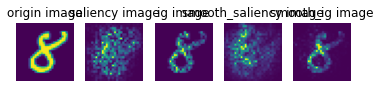

In [35]:
plt.subplot(1, 5, 1)

plt.imshow(np.reshape(sample_image, (28, 28)))
plt.title("origin image")
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(np.reshape(sample_saliency_xai_image, (28, 28)))
plt.title("saliency image")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(np.reshape(sample_ig_xai_image, (28, 28)))
plt.title("ig image")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(np.reshape(sample_smooth_saliency_xai_image, (28, 28)))
plt.title("smooth_saliency image")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(np.reshape(sample_smooth_ig_xai_image, (28, 28)))
plt.title("smooth_ig image")
plt.axis('off')

### XAI 형태로 데이터 추출

In [36]:
ig_x_train = np.zeros_like(x_train)
ig_x_test = np.zeros_like(x_test)

for i in trange(len(ig_x_test)):
    
    ig_x_train[i] = ig(model, x_train[i])
    ig_x_test[i] = ig(model, x_test[i])


100%|██████████| 5000/5000 [02:32<00:00, 32.71it/s]


In [42]:
import pickle
# pickle.dump(ig_x_train, open(f'./dataset/ig_x_train','wb'))
# pickle.dump(ig_x_test, open(f'./dataset/ig_x_test','wb'))

# ig_x_train = pickle.load(open(f'./dataset/ig_x_train','rb'))
# ig_x_test = pickle.load(open(f'./dataset/ig_x_test','rb'))

In [72]:
# 0.687

# inp = keras.Input(shape = (28, 28, 1))
# x = layers.Conv2D(16, 4,strides=2, padding="same", activation="relu")(inp)
# x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(32, 3,strides=1, padding="same", activation="relu")(x)
# x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(64, 5,strides=1, padding="same", activation="relu")(x)

# x = layers.Flatten()(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dense(64, activation="relu")(x)
# out = layers.Dense(10, activation="softmax")(x)

# new_model = keras.Model(inp, out, name="new_model")
# new_model.summary()

# def get_lr_callback(epoch,lr):
#     lr_start   = 0.00001
#     lr_max     = 0.01#0.00000125 * 1 * batch_size
#     lr_min     = 0.0001
#     lr_ramp_ep = 2
#     lr_sus_ep  = 1
#     lr_decay   = 0.7
    
#     def lrfn(epoch):
#         if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
#         elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
#         else:
#             lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
#         return lr
    
#     return lrfn(epoch)

# lr_callback = tf.keras.callbacks.LearningRateScheduler(get_lr_callback, verbose=True)

# new_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
#                 optimizer = tf.keras.optimizers.Adam(), 
#                 metrics=[tf.keras.metrics.CategoricalAccuracy()])
# new_model.fit(ig_x_train, y_train, batch_size = 64,epochs = 20,callbacks=[lr_callback])

In [74]:
# 0.701

# from keras.layers import Dense, MaxPool2D, Flatten, Conv2D, Dropout
# from tensorflow.keras.optimizers import Adam

# model = Sequential()
# model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation = "softmax"))

# model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),metrics =['accuracy'])
# model.fit(
#     ig_x_train,
#     y_train,
#     batch_size=1000,
#     epochs=100,
#     verbose=1,
# )

In [76]:
train_data = np.reshape(ig_x_train, (5000, -1))
test_data = np.reshape(ig_x_test, (5000, -1))

In [77]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(train_data, y_train)
# y_pred = dt_clf.predict(X_test)

# print('예측 정확도: %.2f' % accuracy_score(y_test, y_pred))

DecisionTreeClassifier()

In [78]:
y_pred = dt_clf.predict(test_data)

In [79]:
y_pred

array([1, 0, 8, ..., 5, 9, 0])

In [80]:
for i in trange(len(ig_x_test)):
    submission_csv['label'][i] = y_pred[i]

100%|██████████| 5000/5000 [00:00<00:00, 5209.78it/s]


In [71]:
for i in trange(len(ig_x_test)):
    
    image_data = tf.expand_dims(ig_x_test[i], 0)
    pred = model.predict(image_data)
    pred = np.argmax(pred)

    submission_csv['label'][i] = pred

submission_csv.to_csv('submission.csv', index=False)

100%|██████████| 5000/5000 [02:38<00:00, 31.63it/s]


In [81]:
submission_csv

,file_name,label
0,idx0001.png,1.0
1,idx0002.png,0.0
2,idx0003.png,8.0
3,idx0004.png,3.0
4,idx0005.png,5.0
...,...,...
4995,idx4996.png,5.0
4996,idx4997.png,9.0
4997,idx4998.png,5.0
4998,idx4999.png,9.0


100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


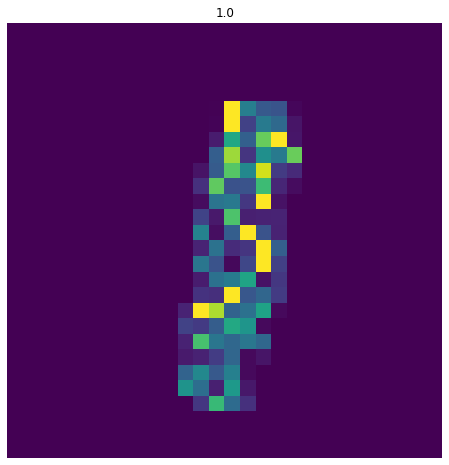

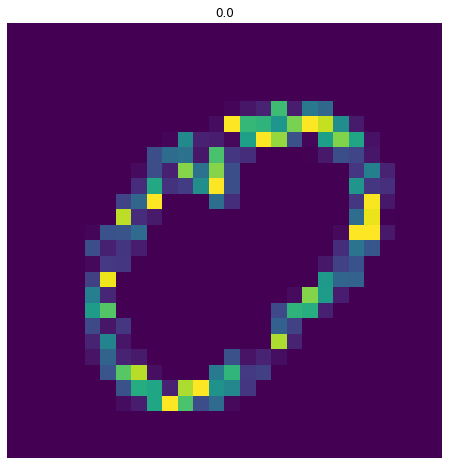

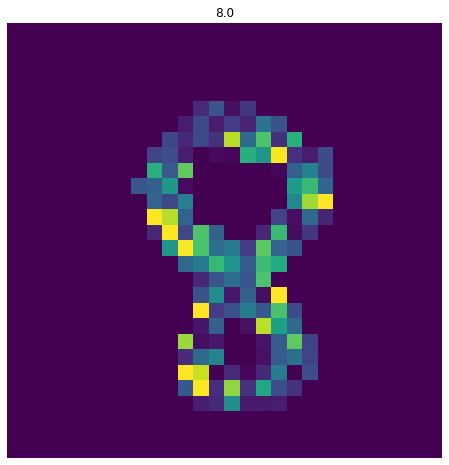

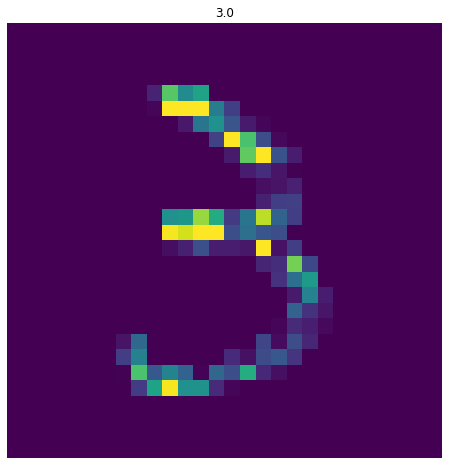

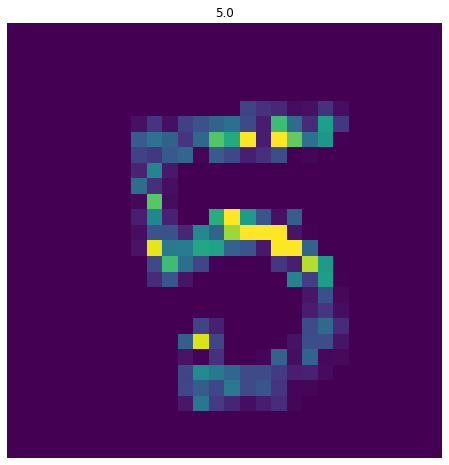

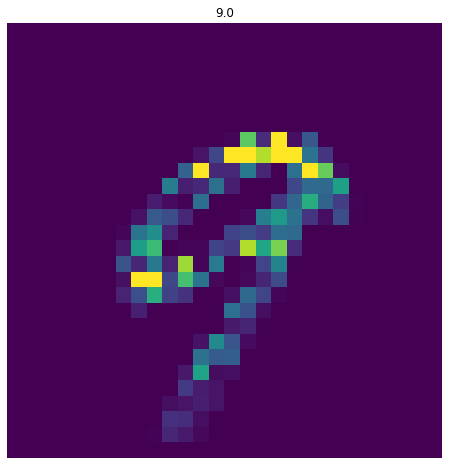

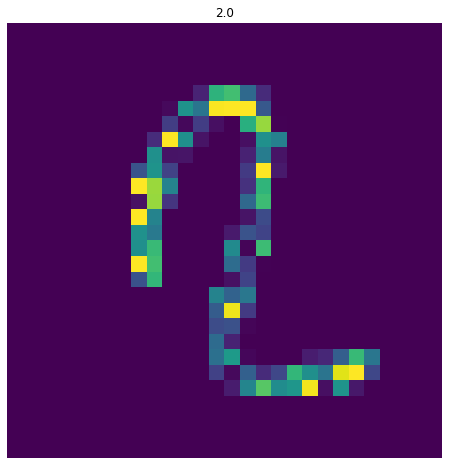

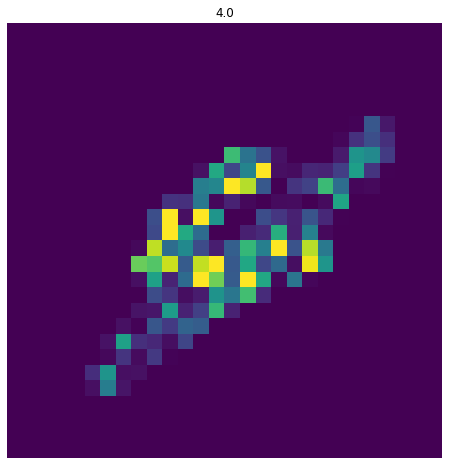

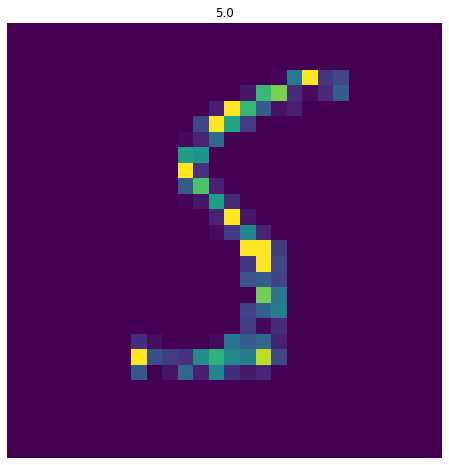

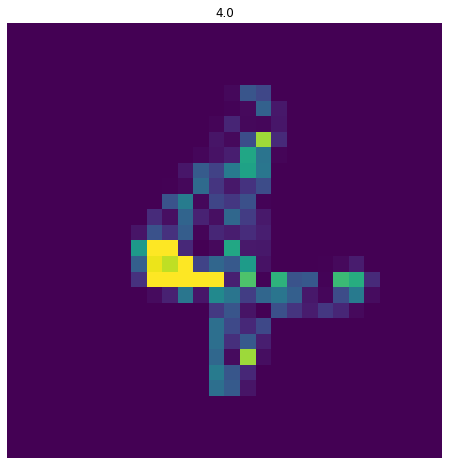

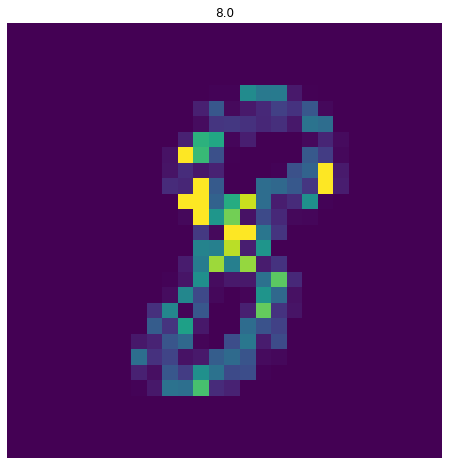

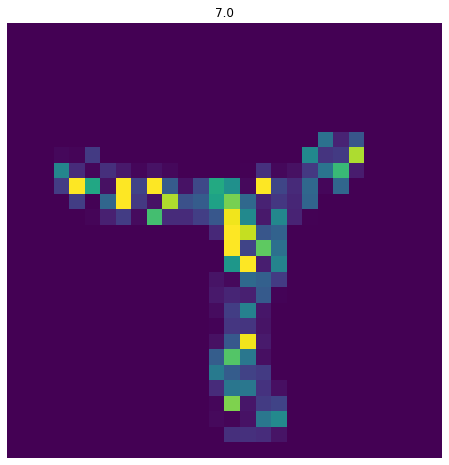

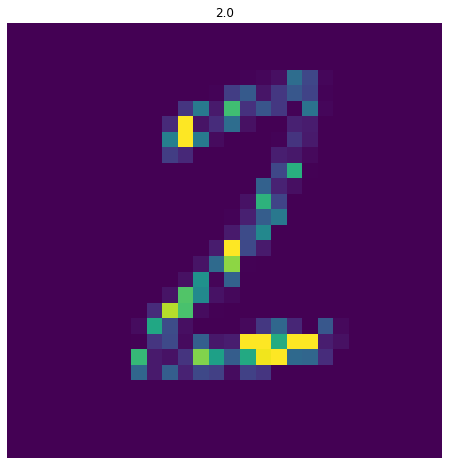

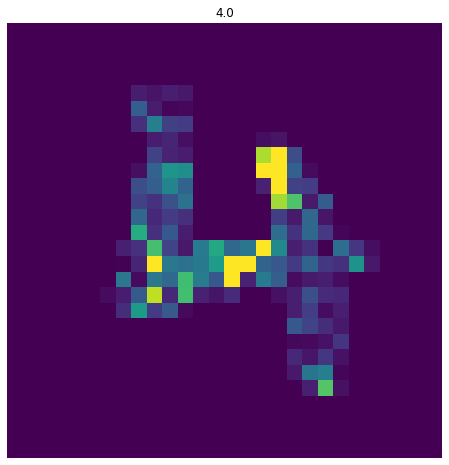

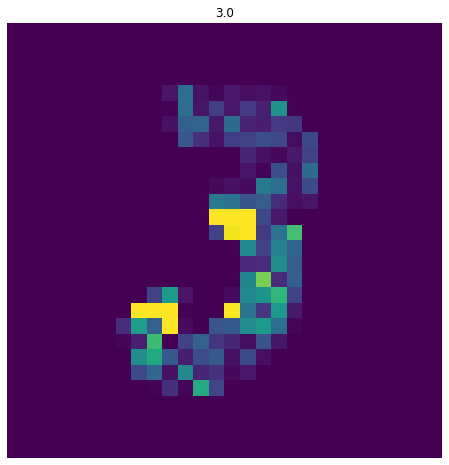

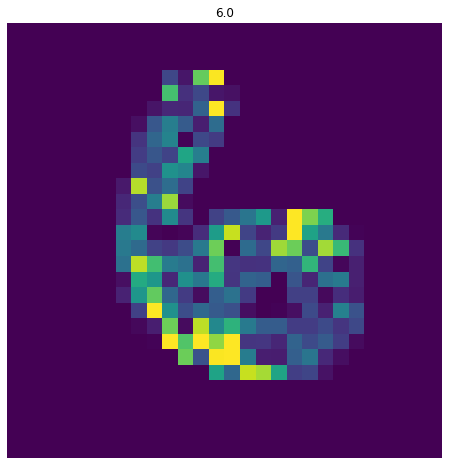

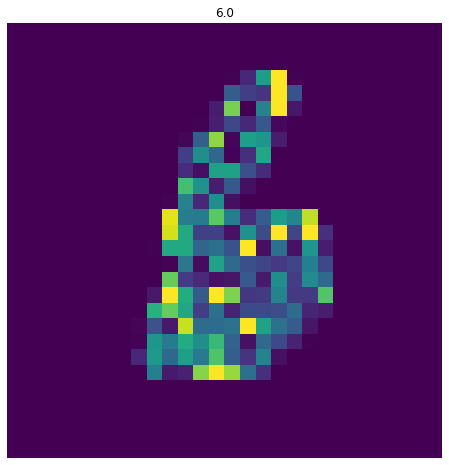

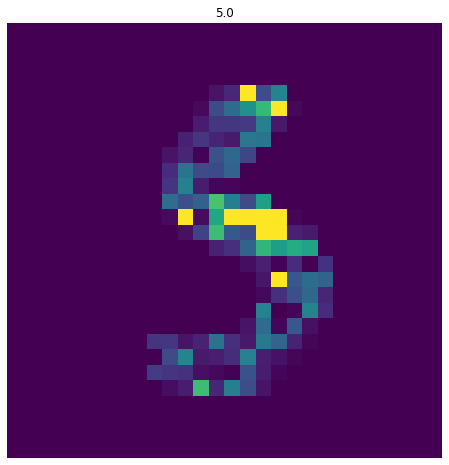

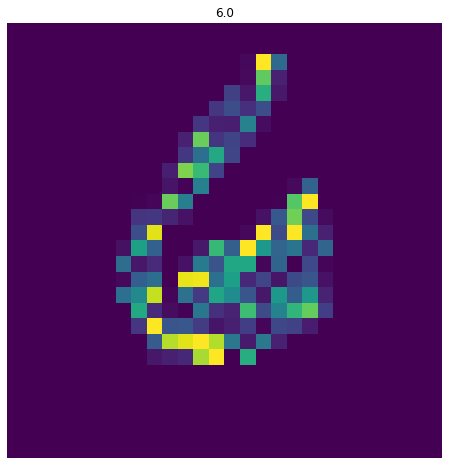

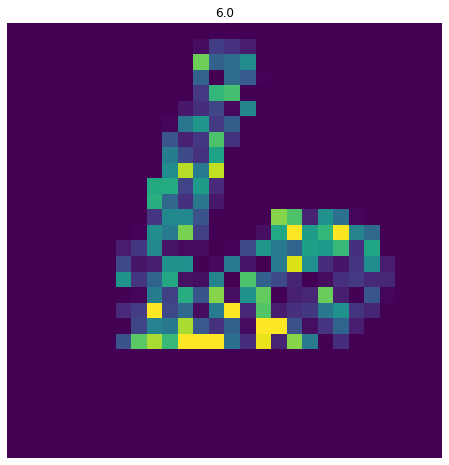

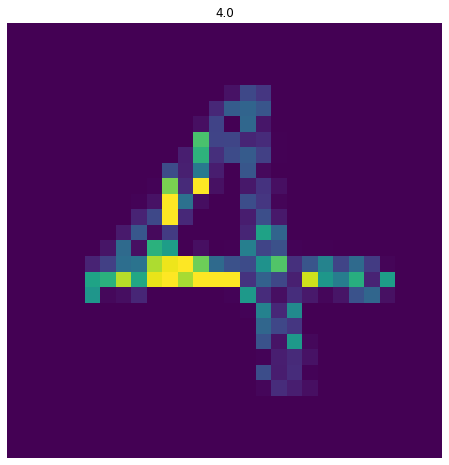

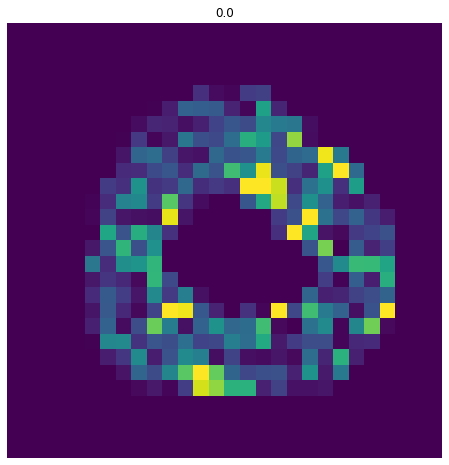

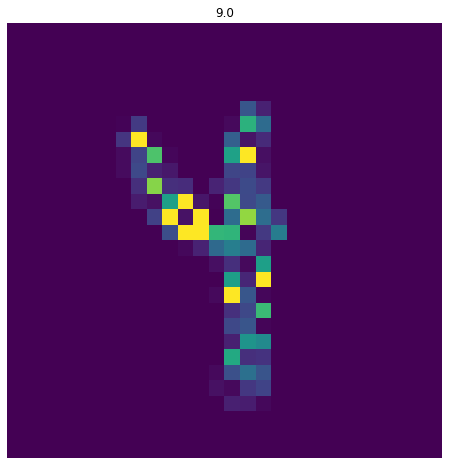

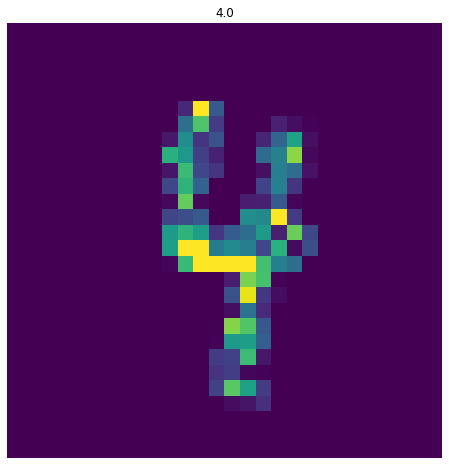

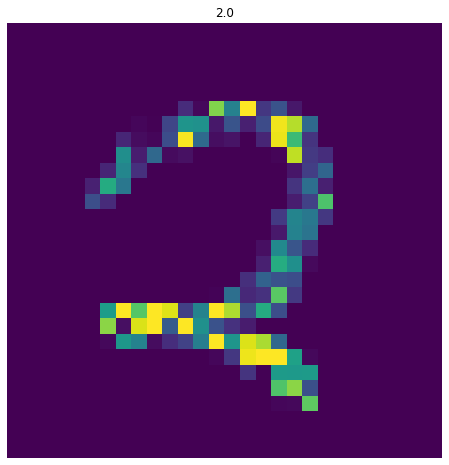

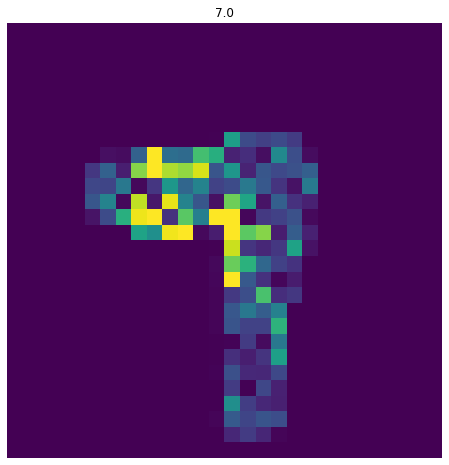

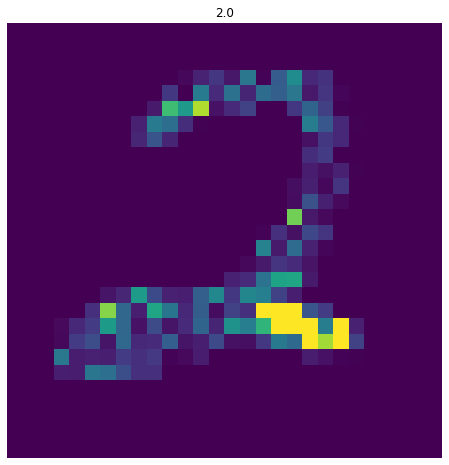

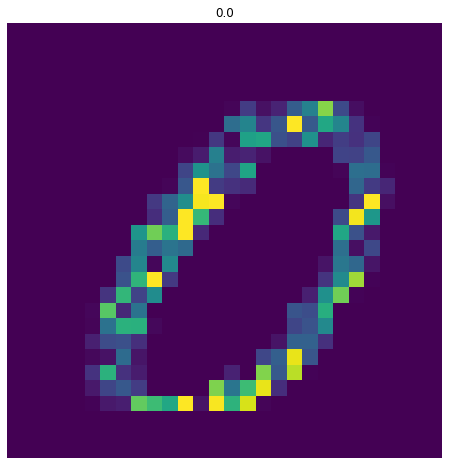

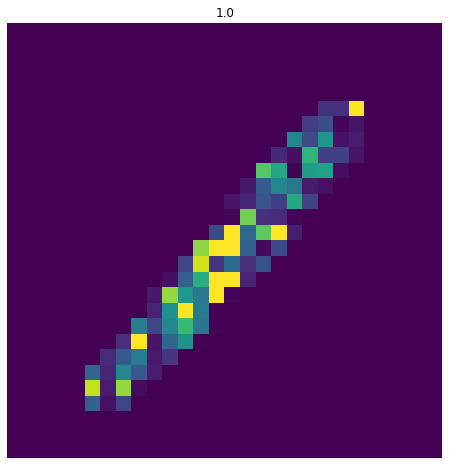

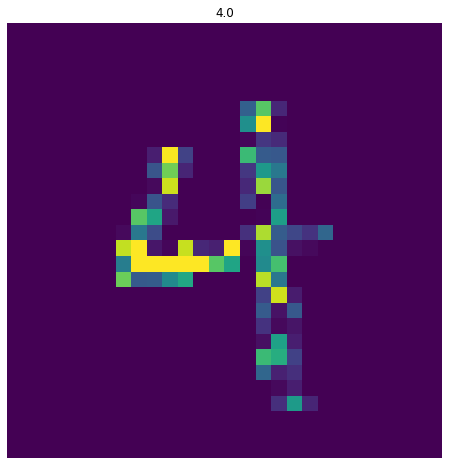

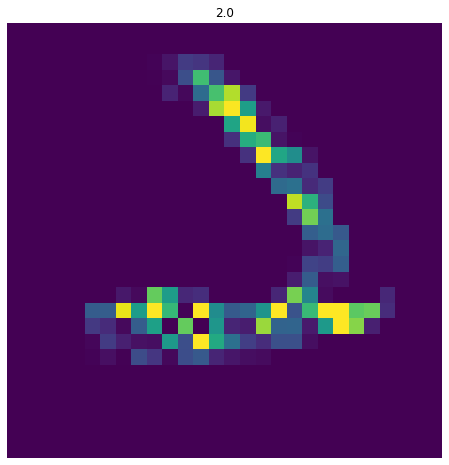

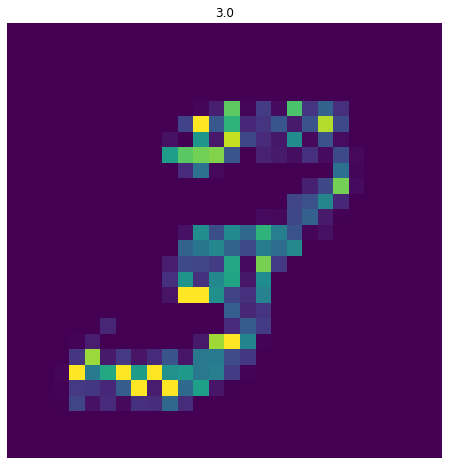

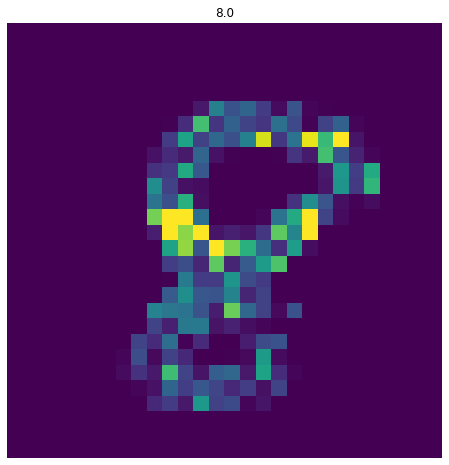

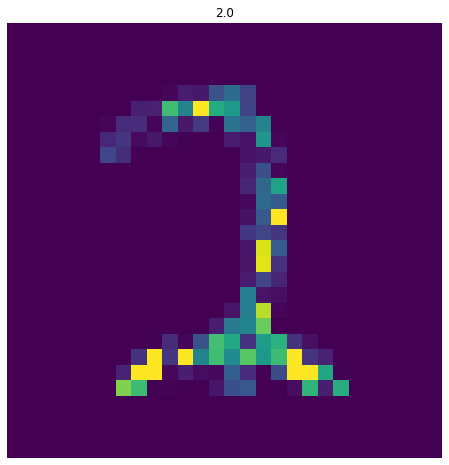

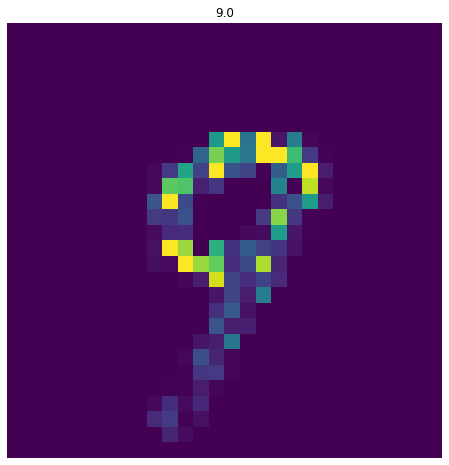

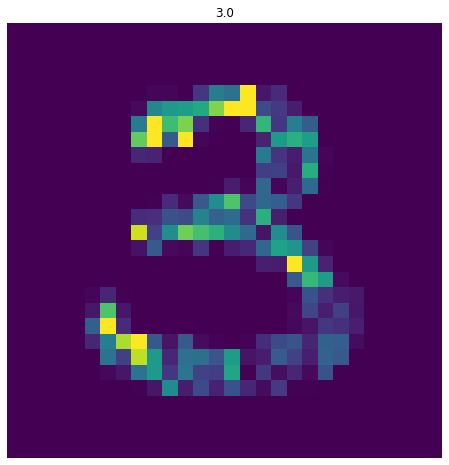

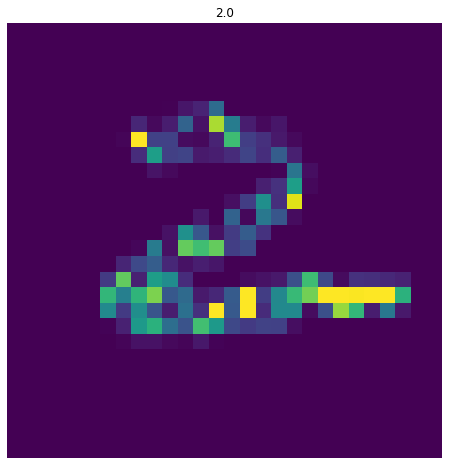

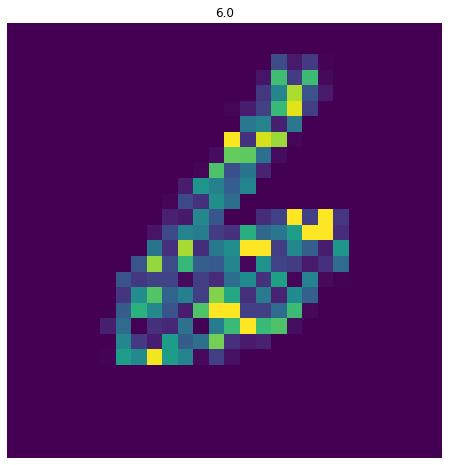

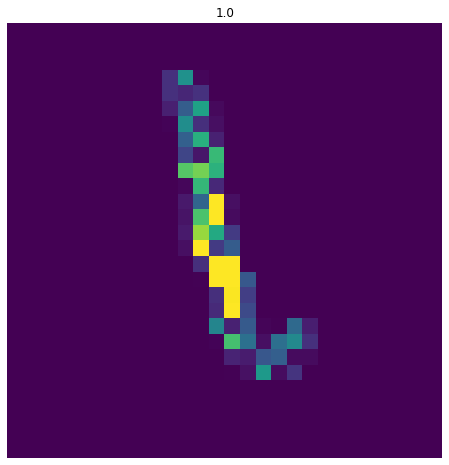

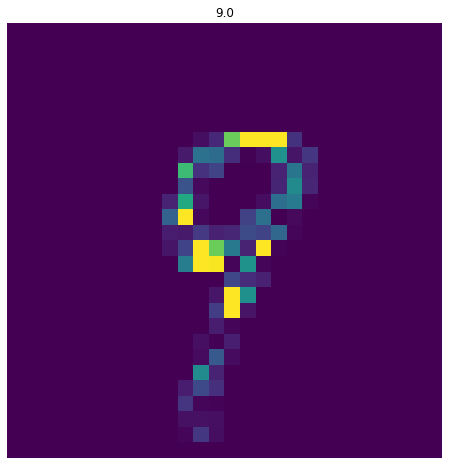

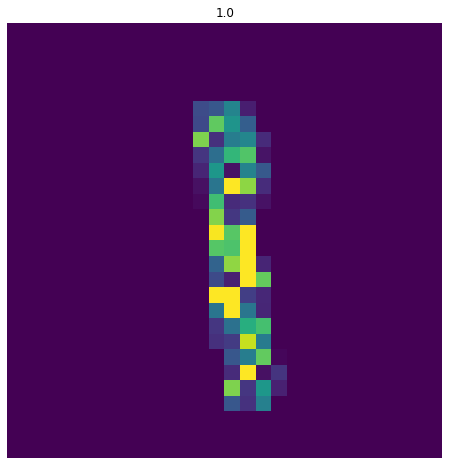

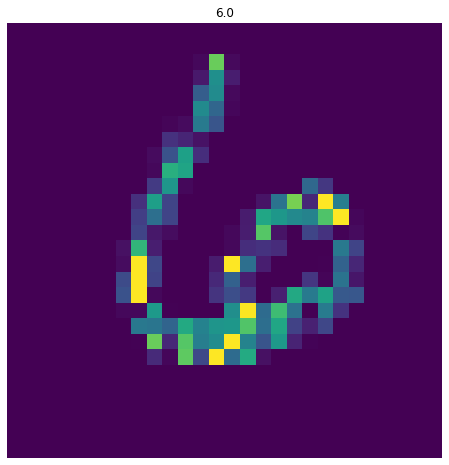

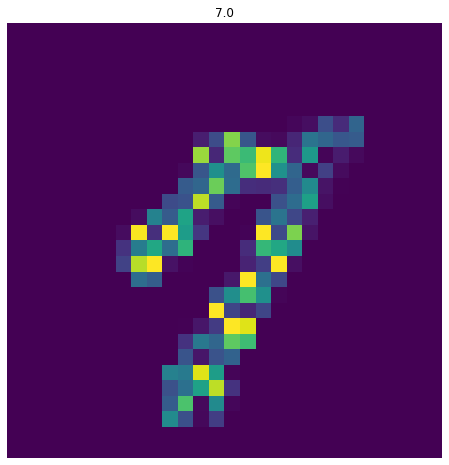

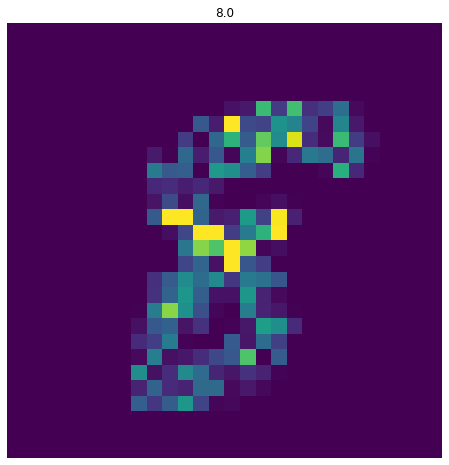

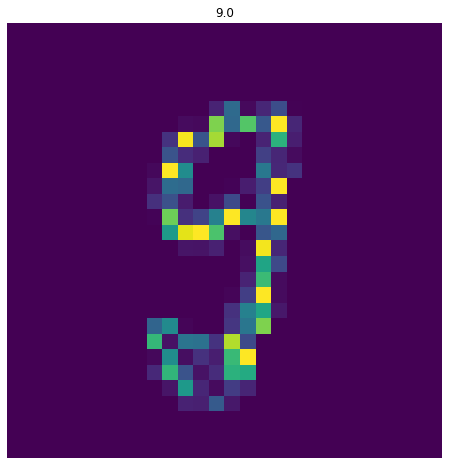

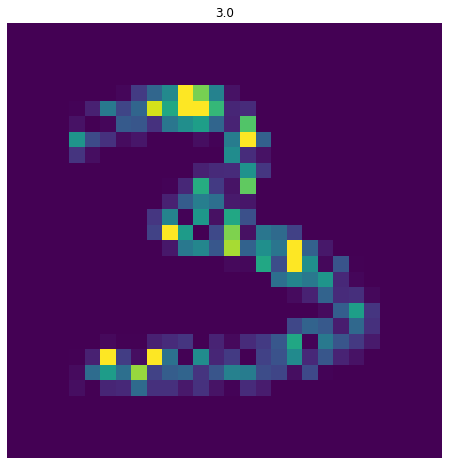

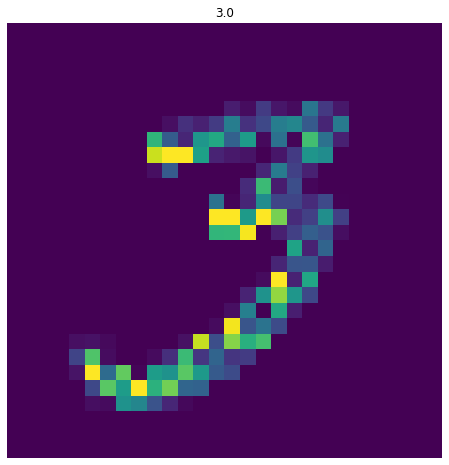

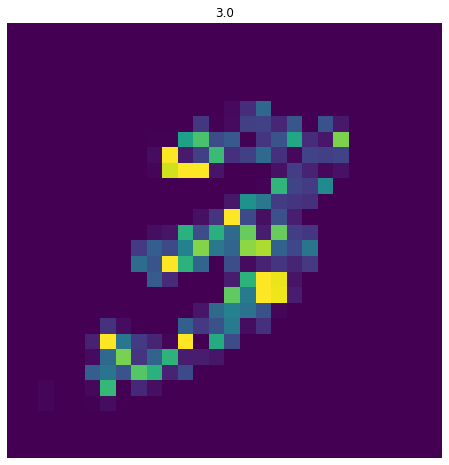

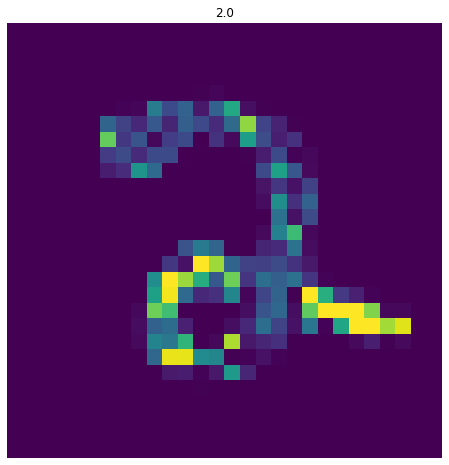

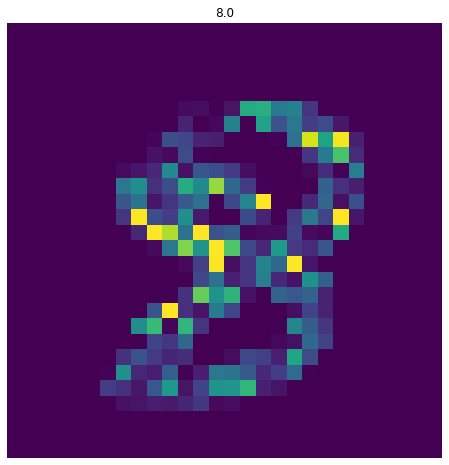

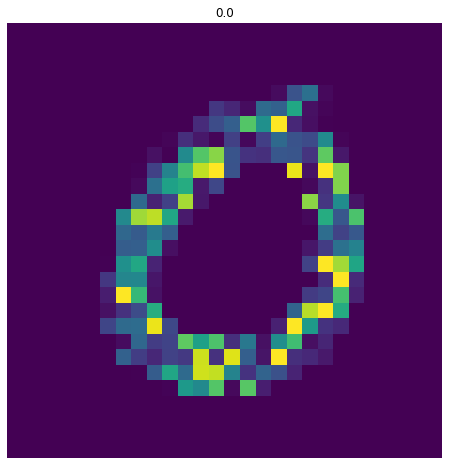

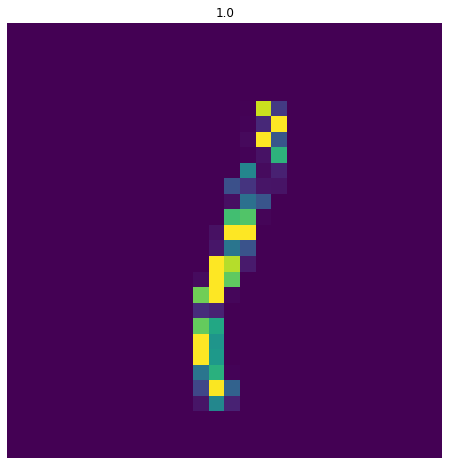

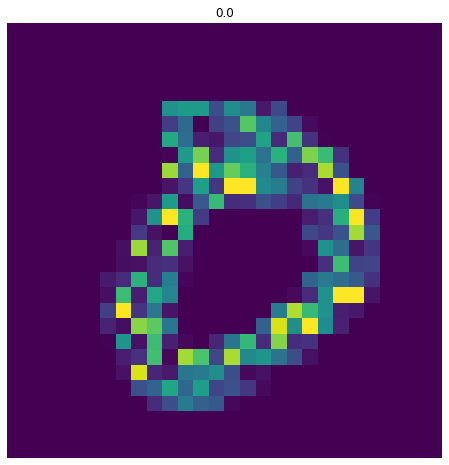

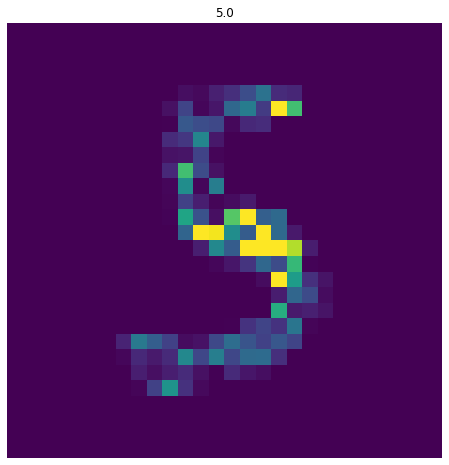

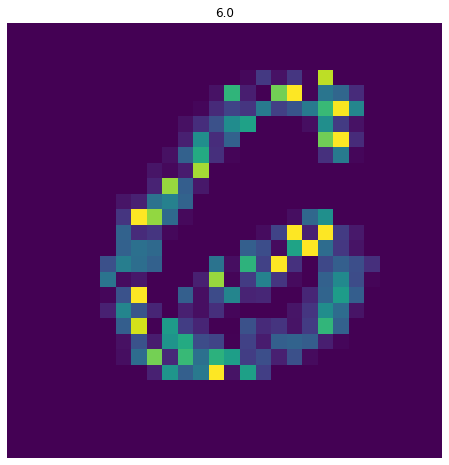

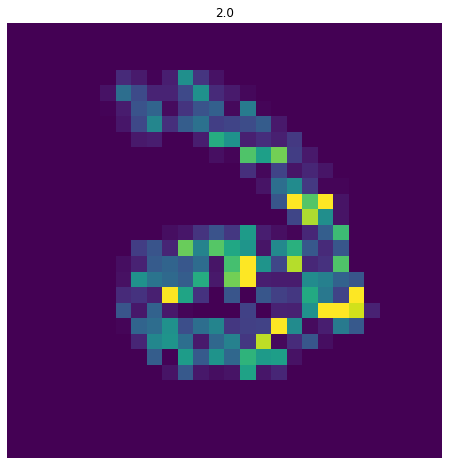

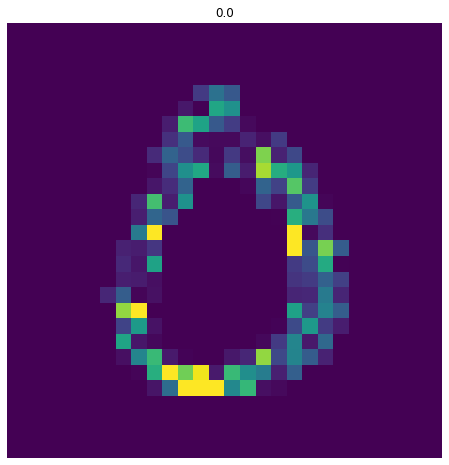

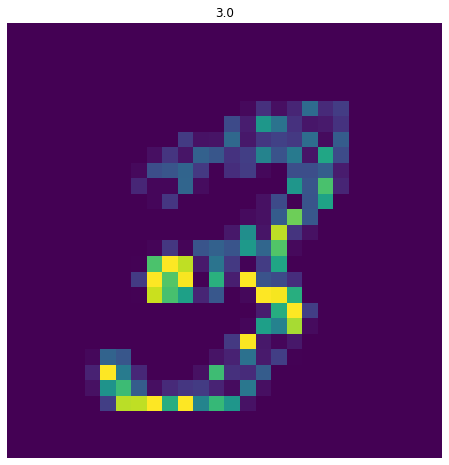

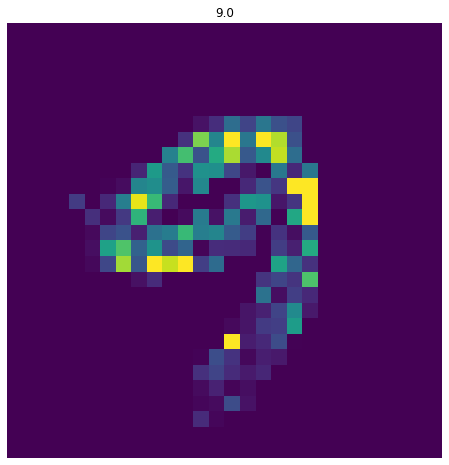

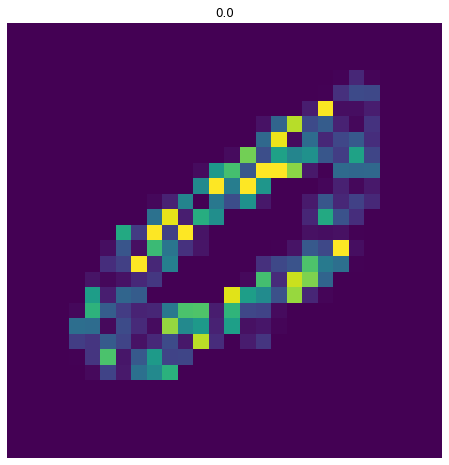

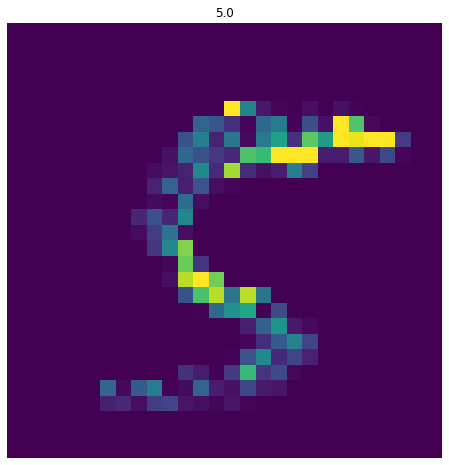

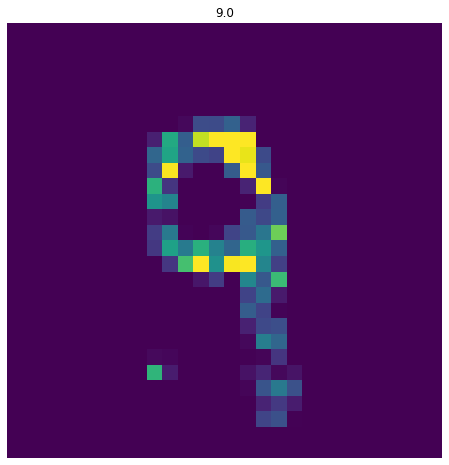

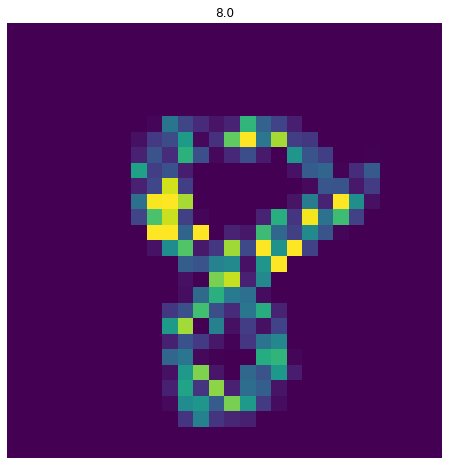

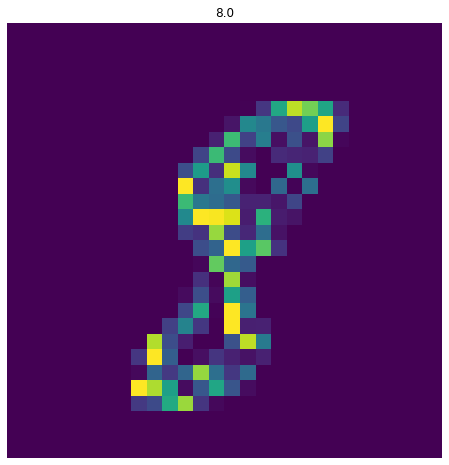

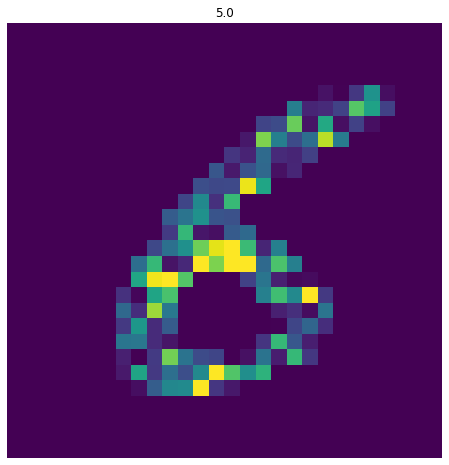

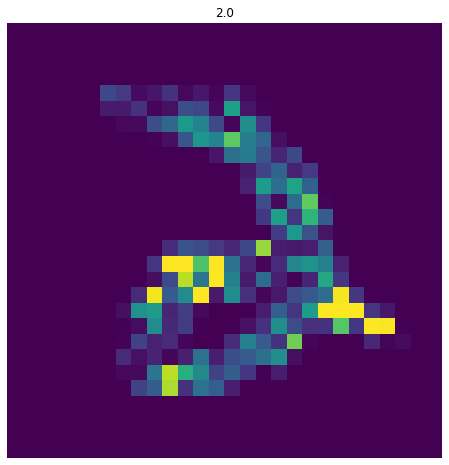

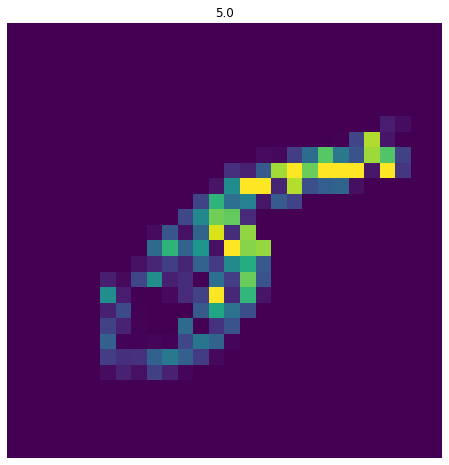

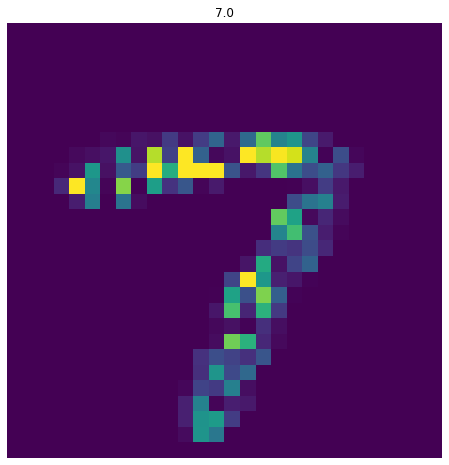

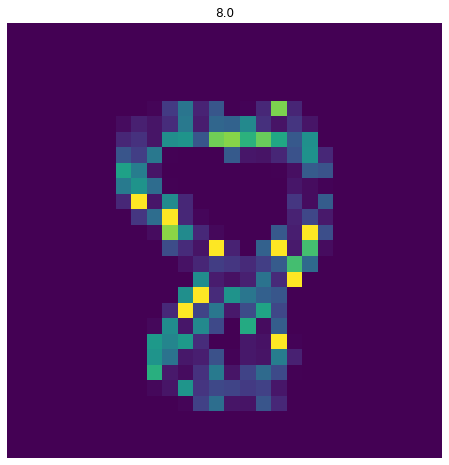

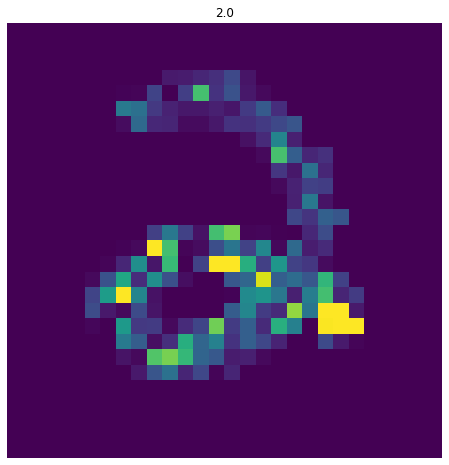

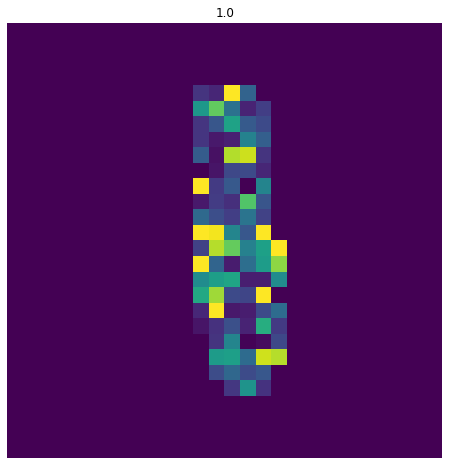

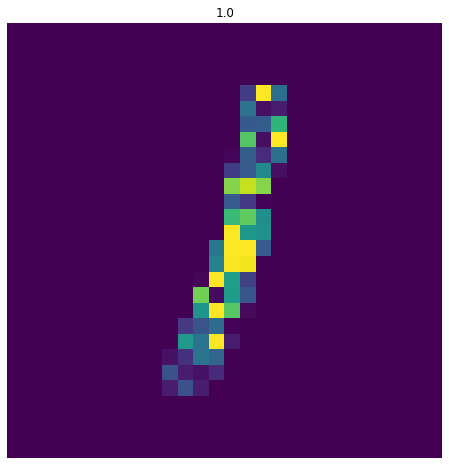

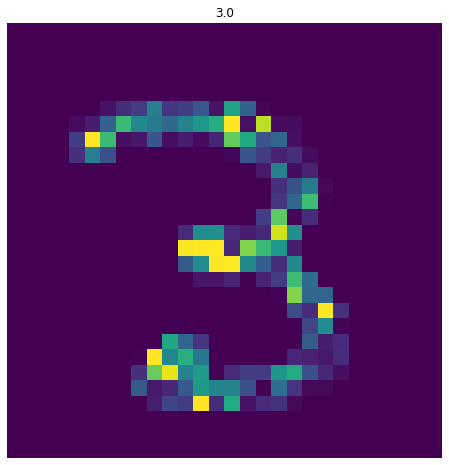

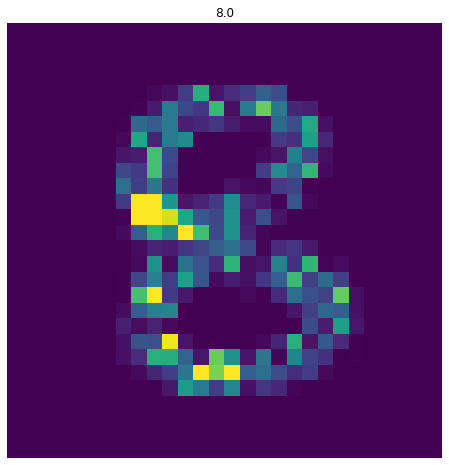

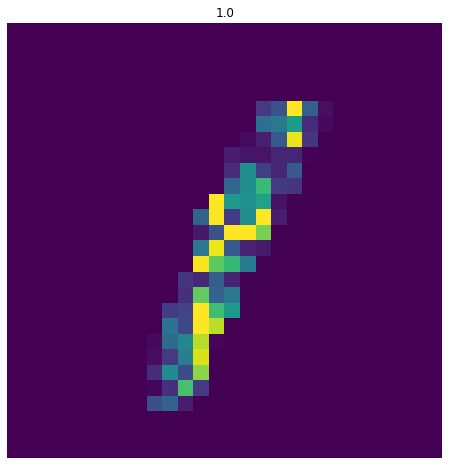

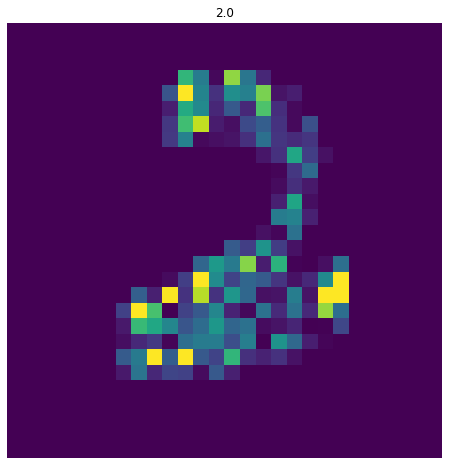

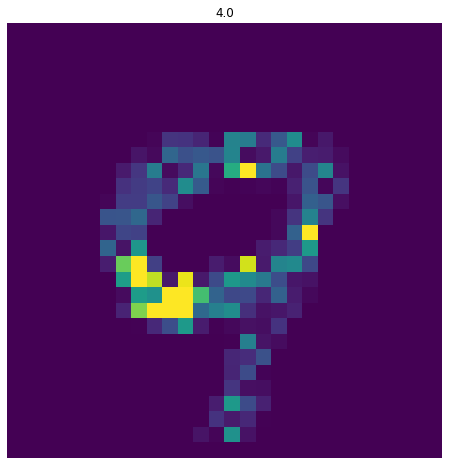

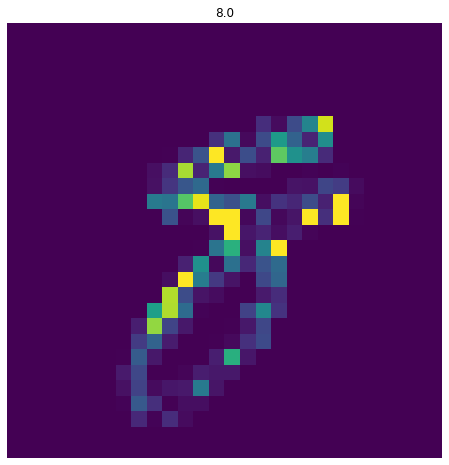

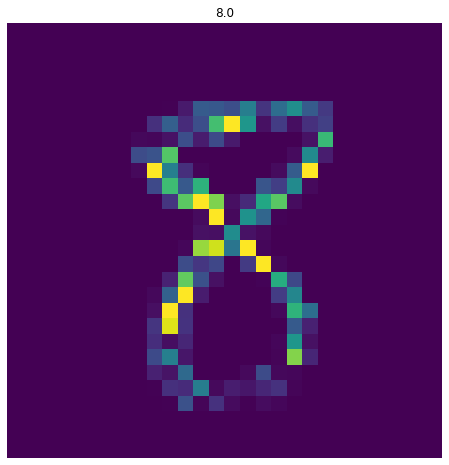

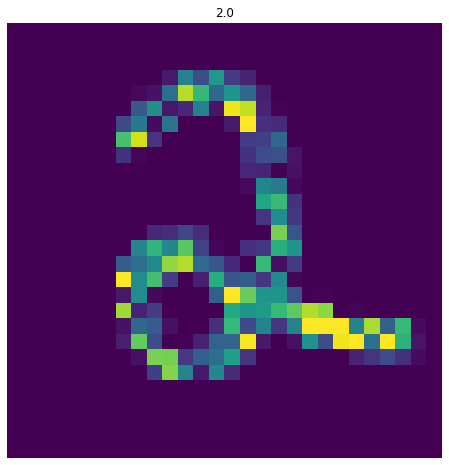

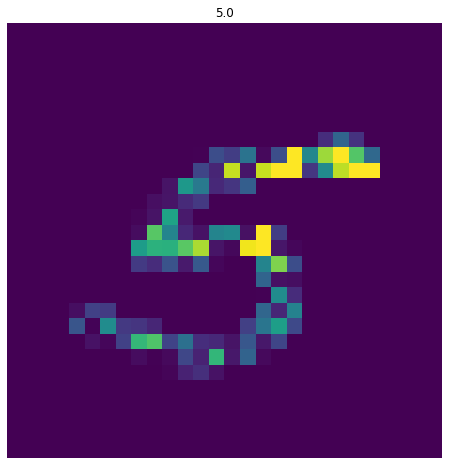

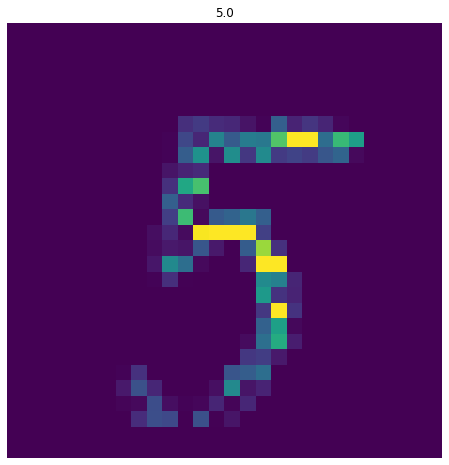

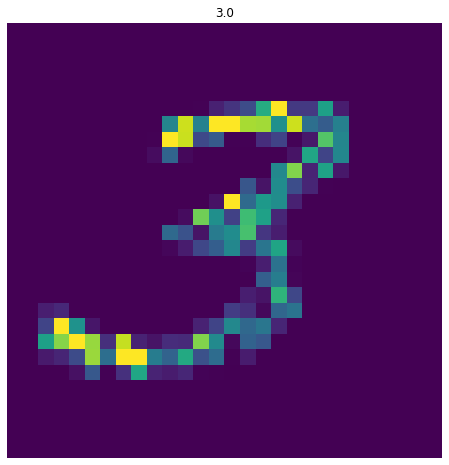

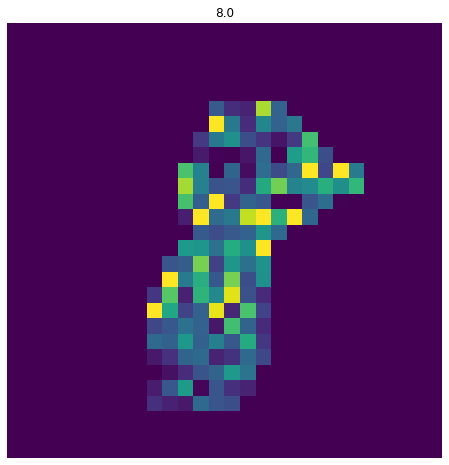

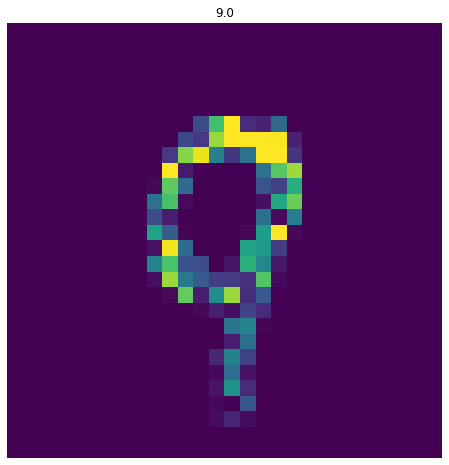

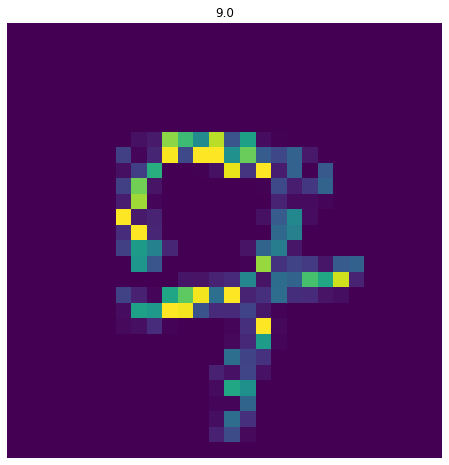

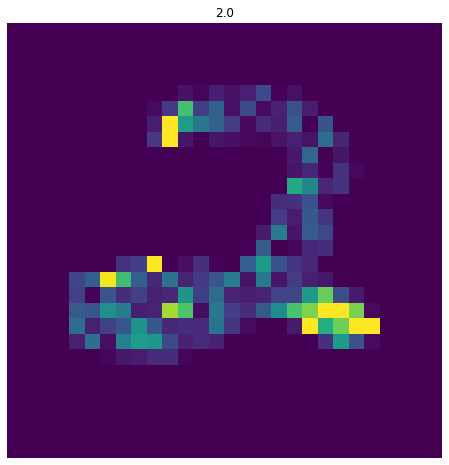

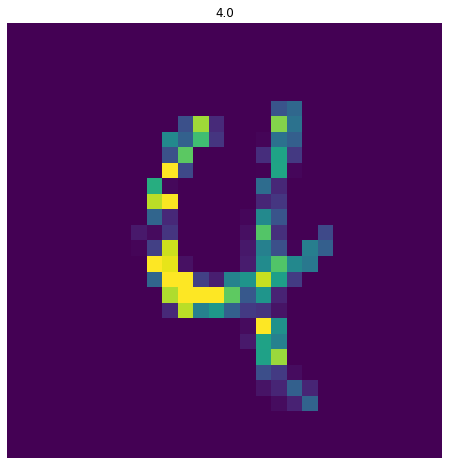

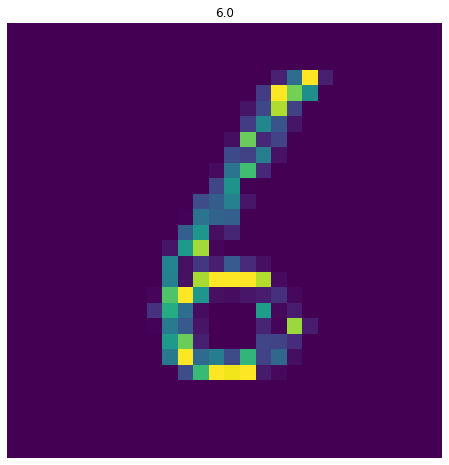

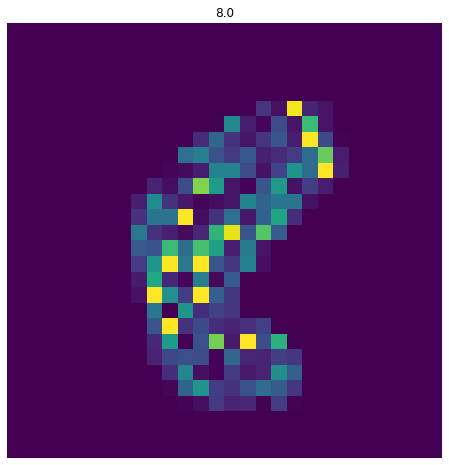

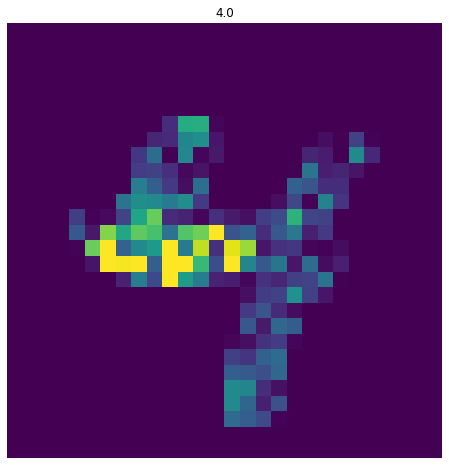

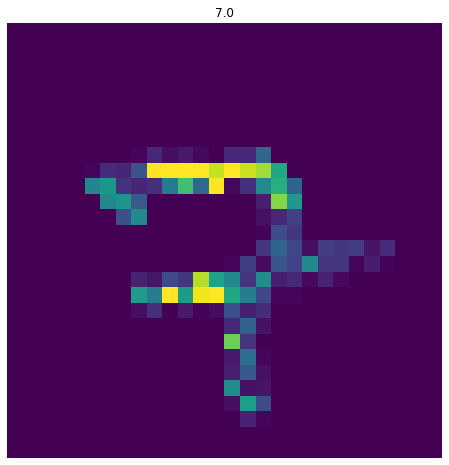

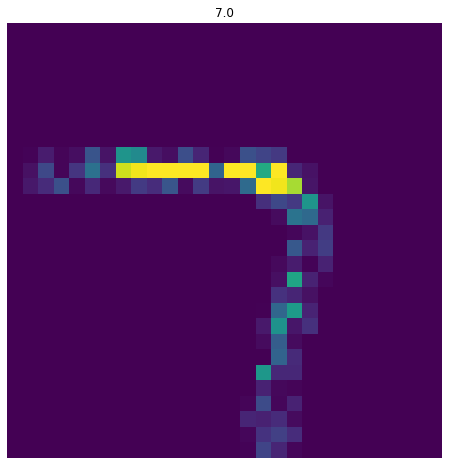

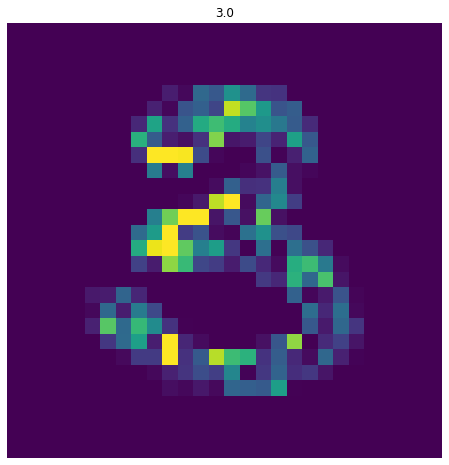

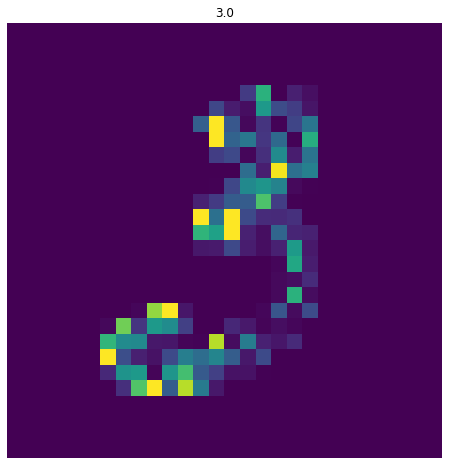

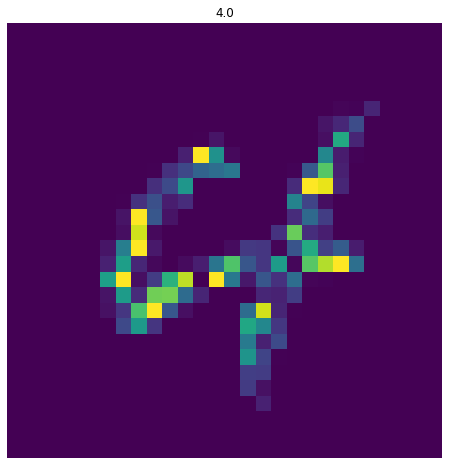

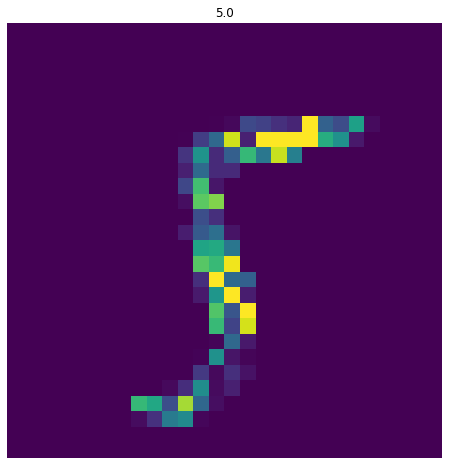

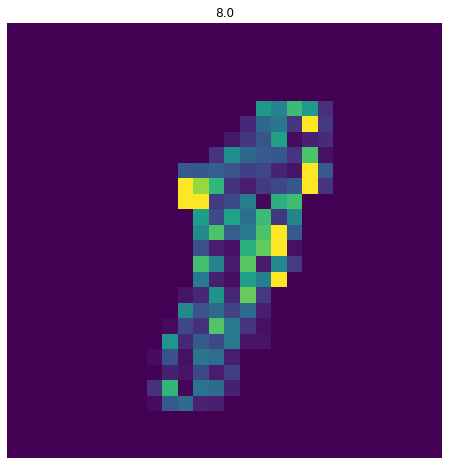

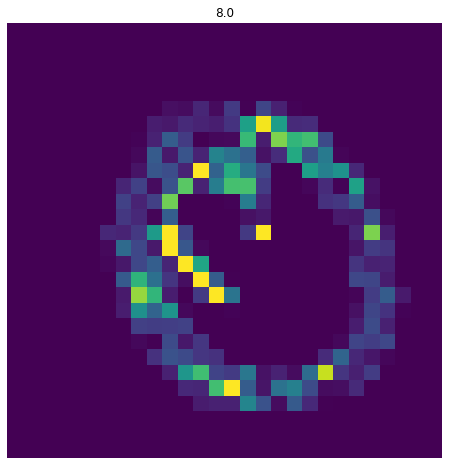

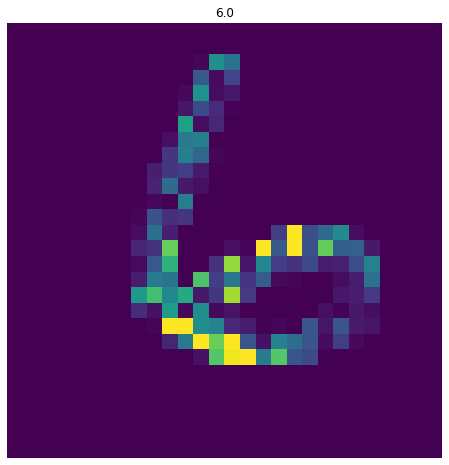

In [65]:
for i in trange(100):
    
    fig, axs = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(8, 8))

    axs[0, 0].imshow(ig_x_test[i])
    axs[0, 0].set_title(submission_csv['label'][i])
    axs[0, 0].axis('off')
